In [ ]:
!pip install nltk
!pip install sklearn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# !wget -O trump_train.tsv https://uc86a09a9e080227baec2fc5c686.dl.dropboxusercontent.com/cd/0/get/Bb3v1RjwQxO_h06PrU1cHGzIpwuwSdWDh7WxSi7USXuVVjtR1Tu5BH3gGIeucXSdSGunuaS1Sng4kLSZm7NTNoahQtTnlUvv5EeZSe6Yzi3lJ4yy9D7M8aKw4RQRtDAcPUnULFUfpHNLW4D0O36drs4L/file?_download_id=88356818103661160667177451500551324168953997065185434572286524337&_notify_domain=www.dropbox.com&dl=1 
drive_path = '/content/drive/MyDrive/NLP/Ex3/'
file_path = drive_path+"trump_train.tsv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Loading the data

In [ ]:
tweets = {
    "tweet_id": [], 
    "user_handle":[], 
    "tweet_text":[], 
    "time_stamp":[], 
    "device":[]
}
with open(file_path) as f:
    lines = f.readlines()
    for line in lines:
        line_splitted = line.split("\t")
        if len(line_splitted)>5:
            print("line too long")
        tweets["tweet_id"].append(line_splitted[0].strip())
        tweets["user_handle"].append(line_splitted[1].strip())
        tweets["tweet_text"].append(line_splitted[2].strip())
        tweets["time_stamp"].append(line_splitted[3].strip())
        tweets["device"].append(line_splitted[4].strip())    


In [ ]:
import pandas as pd
df_tweets = pd.DataFrame(tweets)

##Prerocess


Cleaning and basic preprocessing

In [ ]:
#Formatting the date and time
df_tweets['time_stamp'] = pd.to_datetime(df_tweets['time_stamp'], format='%Y-%m-%d %H:%M:%S')


In [ ]:
import datetime
# Adding a column represnting the time of day
def extract_time_of_day(row):
  time_of_day = row["time_stamp"].to_pydatetime().time()
  datetime_of_day = datetime.datetime(1800, 1, 1, time_of_day.hour, time_of_day.minute, time_of_day.second)
  return datetime_of_day
df_tweets['time_of_day'] = df_tweets.apply(extract_time_of_day, axis=1)
df_tweets['time_of_day'] = pd.to_datetime(df_tweets['time_of_day'], format='%Y-%m-%d %H:%M:%S')


In [ ]:
import datetime
#filtering tweets from before trumps presidency.
trump_inauguration_date = datetime.datetime.strptime("2017-01-20 00:00:01", '%Y-%m-%d %H:%M:%S')
# the date of the inauguration of Donald Trump is the date he took control over the potus twitter account.
# This date is used to filter the tweets.
# all the tweets from the 'PressSec', 'POTUS' handles will be discarded as they may not assist in the learning process. 
# This tweets are from the previous administration and as we aim to train a precise classifier
# these tweets may add unwanted noise to the data.
# These tweets may be "to easy" to separte from Trump's tweets, therfore both skewing the evaluation metrics and hindering the models' ability to separte the more similar tweets. 
# **Rewrite **Test the performances with these tweets labeled as other 
df_tweets = df_tweets[(df_tweets["user_handle"] == "realDonaldTrump")|(df_tweets["user_handle"].isin(['PressSec', 'POTUS'])) & (df_tweets["time_stamp"] > trump_inauguration_date)]

In [ ]:
import re
a_href_regex = re.compile("<a+ (?!(?:href=[\"|']+[http:\/\/]*\.[\/]?.*?[\"|'])) *[^>]*>(.*?)<[/a][^>]>")
# l = a_href_regex.findall(y_str)
def convert_devices(row):
  a_href_device = a_href_regex.findall(row["device"])
  if len(a_href_device)>0: # for simplicity- all devices other than 'android' are labeled "other"
    return "another"
    # return a_href_device[0]
  else:
    return row["device"]

df_tweets["device"] = df_tweets.apply(convert_devices, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


###Label Tagging

In [ ]:
working_hours_start = datetime.time(5, 0, 0)
working_hours_end = datetime.time(23, 0, 0)

def get_label(row, start_time_window=working_hours_start, end_time_window=working_hours_end):
  """
  0-tweet by Trump,1- tweet by another
  """
  label=False
  if row["device"] == "android":
    label=False
  else: #other devices
    if start_time_window<=row["time_stamp"].to_pydatetime().time()<=end_time_window:
      label=True
  return label
  
df_tweets["label"] = df_tweets.apply(get_label, axis=1)

###Brief data exploration

quick data exploration through visualizations

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


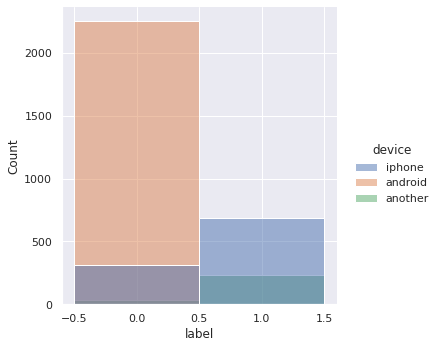

In [ ]:
import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(8,8)})
sns.displot(df_tweets, x="label", hue="device", discrete=True)

The labels are clearly unblanced. Over or under sampling may be used, or a different metric than Accuracy should be used (perhaps auc)

Text(0.5, 1.0, 'Tweets distribution over dates, colored acoording to the devices used to tweet')

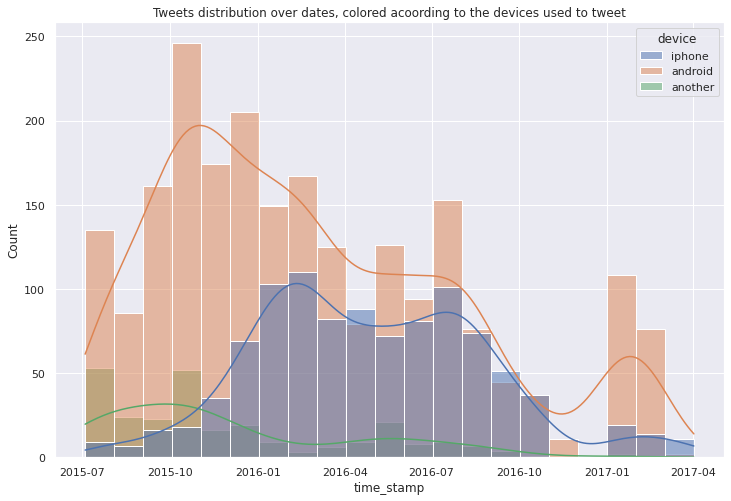

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(df_tweets, x="time_stamp", kde=True, hue="device").set_title("Tweets distribution over dates, colored acoording to the devices used to tweet")

Text(0.5, 1.0, 'Tweets distribution over time of day, colored acoording to the devices used to tweet')

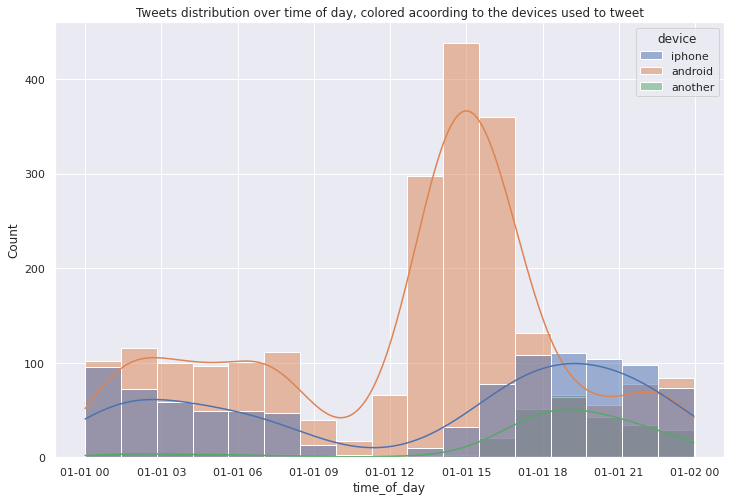

In [ ]:
sns.histplot(df_tweets, x="time_of_day", kde=True, hue="device").set_title("Tweets distribution over time of day, colored acoording to the devices used to tweet")

Text(0.5, 1.0, 'Tweets distribution over time of day, colored acoording to the devices used to tweet')

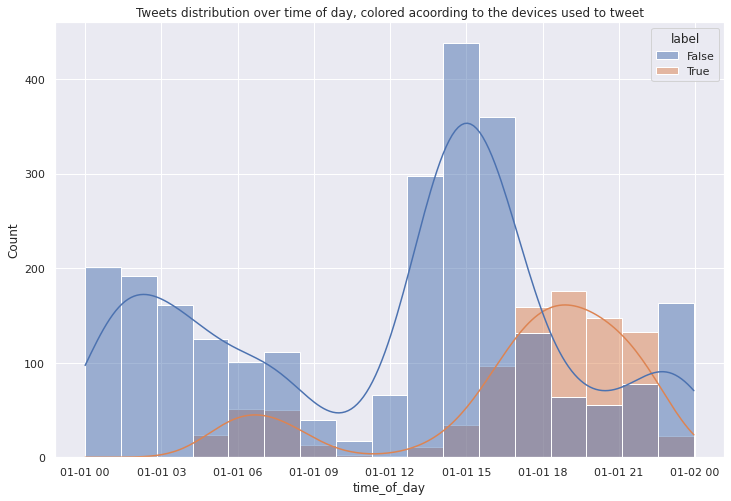

In [ ]:
sns.histplot(df_tweets, x="time_of_day", kde=True, hue="label").set_title("Tweets distribution over time of day, colored acoording to the devices used to tweet")

Text(0.5, 1.0, "Tweets' lengths distribution, colored acoording to the devices used to tweet")

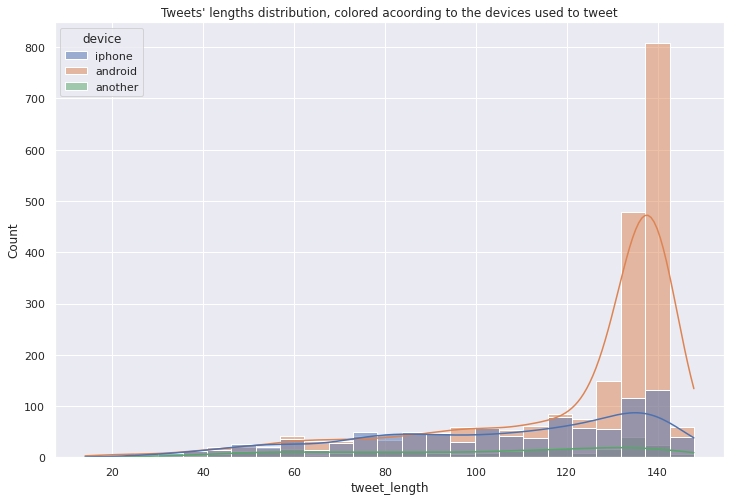

In [ ]:
df_tweets["tweet_length"] = df_tweets["tweet_text"].apply(lambda x: len(x))

sns.histplot(df_tweets, x="tweet_length", kde=True, hue="device").set_title("Tweets' lengths distribution, colored acoording to the devices used to tweet")

###Features extraction

tokenization, stop words removal, length, embeddings...

In [ ]:
import nltk
import string
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('word2vec_sample')
from nltk.corpus import stopwords          
from nltk.stem import PorterStemmer       
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


In [ ]:
pos_translation = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'} 
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stopwords_en = stopwords.words('english')


def get_tweet_tokens(tweet):
  tokens = tokenizer.tokenize(tweet)
  return tokens

def clean_text(text):
  norm_text = text.lower()
  norm_text = re.sub('([.,!?()\n])', r' \1 ', norm_text)
  norm_text = re.sub('\s{2,}', ' ', norm_text)
  norm_text = re.sub(r"\b's\b", '', norm_text)
  norm_text = re.sub(r'https?:\/\/.*[\r\n]*', '', norm_text)
  norm_text = re.sub(r'#', '', norm_text)
  return norm_text

# def lemmatize(tweet):
#   norm_tweet = []
#   for word in tweet:
#       norm_word = lemmatizer.lemmatize(word)
#       norm_tweet.append(norm_word)
#   return norm_tweet

# def pos_tagging_type_1(tweet):
#   pos = []
#   for word in tweet:
#     pos.append(nltk.pos_tag([word])[0][1])#[:2]
#   return pos

# def pos_tagging_type_2(tweet):
#   pos = []
#   for word in tweet:
#     curr_pos = nltk.pos_tag([word])[0][1][:2]
#     if curr_pos in pos_translation:
#       curr_pos_type_2 = pos_translation[curr_pos]
#     else: 
#       curr_pos_type_2 = 'n' # default to noun
#     pos.append(curr_pos_type_2)
#   return pos

# def remove_stop_words(tweet):
#   norm_tweet = []
#   for word in tweet:
#     if word not in stopwords_en:
#       norm_tweet.append(word)
#   return norm_tweet

# def remove_punctuation(tweet):
#   norm_tweet = []
#   for word in tweet:
#     if word not in string.punctuation:
#       norm_tweet.append(word)
#   return norm_tweet

In [ ]:
def process_tweet(tweet, remove_punctuations=True, remove_stopwords=True, lemmatization=True):
  norm_tokens = []
  norm_tokens_pos_tag = [] #(token, lemmetize_token, stem_token pos_type_1, pos_type_2) maybe add tf-idf
  
  clean_tweet = clean_text(tweet)
  tweet_tokens = get_tweet_tokens(clean_tweet)
  for tweet_token in tweet_tokens:
    if remove_punctuations:
      if tweet_token in string.punctuation:
        continue #skip punctuation
    if remove_stopwords:
      if tweet_token in stopwords_en:
        continue #skip punctuation
        
    #POS Tagging
    pos_type_1 = nltk.pos_tag([tweet_token])[0][1]

    # lemmatization:
    if pos_type_1[:2] in pos_translation:
      pos_type_2 = pos_translation[pos_type_1[:2]]
    else: 
      pos_type_2 = 'n' # default to noun
    lem_token = lemmatizer.lemmatize(tweet_token, pos=pos_type_2)

    #stemming
    stem_token = stemmer.stem(tweet_token)  # stemming word

    if lemmatization:
      norm_tokens.append(lem_token)
    else:
      norm_tokens.append(tweet_token)
    # norm_tokens_pos_tag.append((tweet_token,lem_token,stem_token,pos_type_1,pos_type_2))
  
  # return norm_tokens, norm_tokens_pos_tag
  # return norm_tokens_pos_tag
  return norm_tokens

print(df_tweets.iloc[1]["tweet_text"])
print(process_tweet(df_tweets.iloc[1]["tweet_text"]))

General Kelly is doing a great job at the border. Numbers are way down. Many are not even trying to come in anymore.
['general', 'kelly', 'great', 'job', 'border', 'number', 'way', 'many', 'even', 'try', 'come', 'anymore']


In [ ]:
df_tweets["tweet_tokens"] = df_tweets["tweet_text"].apply(process_tweet)


Text(0.5, 1.0, "Tweets' tokens lengths distribution, colored acoording to the devices used to tweet")

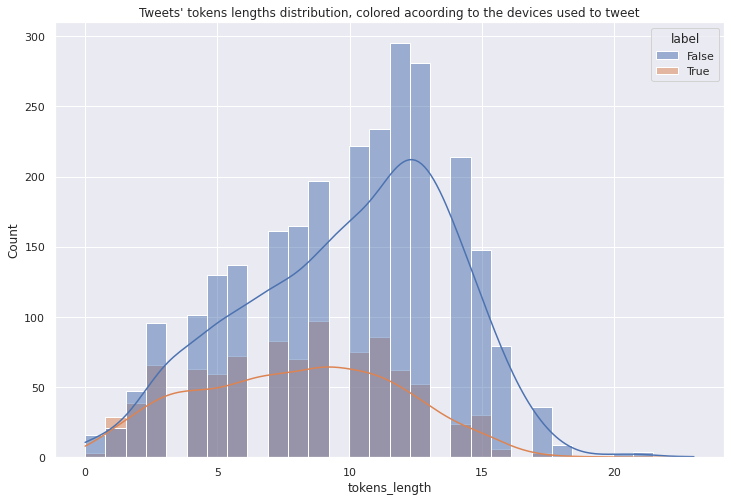

In [ ]:
df_tmp = df_tweets.copy(deep=True)
df_tmp["tokens_length"] = df_tweets["tweet_tokens"].apply(lambda x: len(x))

sns.histplot(df_tmp, x="tokens_length", kde=True, hue="label").set_title("Tweets' tokens lengths distribution, colored acoording to the devices used to tweet")

###TF-IDF

In [ ]:
# tweets_tokens = list(df_tweets["tweet_tokens"].apply(lambda x: ' '.join(x)))

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# # our corpus

# count_vectorizer = CountVectorizer()

# # convert text data into term-frequency matrix
# data = count_vectorizer.fit_transform(tweets_tokens)

# tfidf_transformer = TfidfTransformer()

# # convert term-frequency matrix into tf-idf
# tfidf_matrix = tfidf_transformer.fit_transform(data)

# # create dictionary to find a tfidf word each word
# word2tfidf = dict(zip(count_vectorizer.get_feature_names(), tfidf_transformer.idf_))

# word2tfidf

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf_vectorizer = TfidfVectorizer()
# tfidf = tfidf_vectorizer.fit_transform(tweets_tokens)

In [ ]:
# tfidf[1231]

In [ ]:
# tfidf_vectorizer.

###Creating sequences of the same length
chosen length = 10

every tweet is sliced into sequences of 10

Example:
"General Kelly is doing a great job at the border. Numbers are way down. Many are not even trying to come in anymore."

has been tokenized to:


*   ['general', 'kelly', 'great', 'job', 'border', 'number', 'way', 'many', 'even', 'try', 'come', 'anymore']




and then splitted into:
1.   ['general', 'kelly', 'great', 'job', 'border', 'number', 'way', 'many', 'even', 'try']
2.   ['great', 'job', 'border', 'number', 'way', 'many', 'even', 'try', 'come', 'anymore']




In [ ]:
def pad_tweet(tweet, pad_str='~', n=10):
  padded_tweet = tweet
  pad_count = n-len(tweet)
  for _ in range(pad_count):
    padded_tweet.append(pad_str)
  return padded_tweet

In [ ]:
# from nltk.util import pad_sequence
import math
def split_tweet(tweet, n=10):
  splited_tweet = []
  num_of_splits = math.ceil(len(tweet)/n)
  
  if num_of_splits==1: #length of tweet is shortet than n
    splited_tweet.append(pad_tweet(tweet))
    # splited_tweet.append(list(pad_sequence(tweet, n=n)))
  else:
    for i in range(num_of_splits):
      start = i*n
      end = start+n
      if end > len(tweet): #if the tweet is ending slice a portion 
        splited_tweet.append(tweet[-n:])
      else:
        splited_tweet.append(tweet[start:end])
  return splited_tweet

df_tweets["splitted_tweet_tokens"] = df_tweets["tweet_tokens"].apply(split_tweet)

In [ ]:
rows = []
for _, row in df_tweets.iterrows():
  for tweet_section in row["splitted_tweet_tokens"]:
    rows.append({'tweet_id': row['tweet_id'], 'time_stamp': row['time_stamp'], 'tokens': tweet_section, 'tweet_length': row['tweet_length'], 'label': row['label']})#, ignore_index=True)
df_splitted_tweets = pd.DataFrame(rows)
df_splitted_tweets

,tweet_id,time_stamp,tokens,tweet_length,label
0,845974102619906048,2017-03-26 15:21:58,"[democrat, smile, c, freedom, caucus, help, cl...",144,True
1,845974102619906048,2017-03-26 15:21:58,"[freedom, caucus, help, club, growth, heritage...",144,True
2,846166053663191040,2017-03-27 04:04:42,"[general, kelly, great, job, border, number, w...",116,False
3,846166053663191040,2017-03-27 04:04:42,"[great, job, border, number, way, many, even, ...",116,False
4,835814988686233601,2017-02-26 13:33:16,"[race, dnc, chairman, course, totally, rig, be...",138,False
...,...,...,...,...,...
5068,722818508665454593,2016-04-20 19:05:36,"[trump, 360, watch, 360, video, speech, last, ...",94,True
5069,722920297393995776,2016-04-21 01:50:04,"[thank, indiana, back, soon, trump, 2016, make...",95,False
5070,722967660833722369,2016-04-21 04:58:17,"[meeting, terrific, indiana, excite, campaign,...",126,False
5071,722967703313612802,2016-04-21 04:58:27,"[go, bring, steel, manufacturing, back, indian...",62,False


In [ ]:
df_tweets = df_tweets[['tweet_id', 'time_stamp', 'tweet_tokens', 'label', 'tweet_length']]
df_tweets

,tweet_id,time_stamp,tweet_tokens,label,tweet_length
0,845974102619906048,2017-03-26 15:21:58,"[democrat, smile, c, freedom, caucus, help, cl...",True,144
1,846166053663191040,2017-03-27 04:04:42,"[general, kelly, great, job, border, number, w...",False,116
2,835814988686233601,2017-02-26 13:33:16,"[race, dnc, chairman, course, totally, rig, be...",False,138
3,835817351178301440,2017-02-26 13:42:39,"[first, time, fail, take, ad, bad, one, help, ...",False,139
4,835916511944523777,2017-02-26 20:16:41,"[russia, talk, fake, news, put, dems, played, ...",False,137
...,...,...,...,...,...
3523,722818508665454593,2016-04-20 19:05:36,"[trump, 360, watch, 360, video, speech, last, ...",True,94
3524,722920297393995776,2016-04-21 01:50:04,"[thank, indiana, back, soon, trump, 2016, make...",False,95
3525,722967660833722369,2016-04-21 04:58:17,"[meeting, terrific, indiana, excite, campaign,...",False,126
3526,722967703313612802,2016-04-21 04:58:27,"[go, bring, steel, manufacturing, back, indian...",False,62


###Embeddings

In [ ]:
# !pip install --upgrade gensim

In [ ]:
# import gensim
# from nltk.data import find
# import numpy as np


# #loadding word2vec embeddings - the length of each encoding is 300
# word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
# embed_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)
# #add the padding cahracter to the embeddings model with a zero vector
# embed_model['~'] = np.zeros(embed_model.vector_size)
# print(f"length of embedding: {embed_model.vector_size}")

In [ ]:
# from gensim.test.utils import datapath
# from gensim.models import fasttext

# cap_path = datapath("crime-and-punishment.bin")
# fbkv = fasttext.load_facebook_vectors(cap_path)

In [ ]:
# fbkv

In [ ]:
# !pip install fasttext

In [ ]:
import pickle
# import fasttext.util

# def generate_embedding_dict(embed_path = "embeddings.pkl"):
#   fasttext.util.download_model('en', if_exists='ignore')  # English
#   ft = fasttext.load_model('cc.en.300.bin')
#   count=0
#   words_not_in_embed_vocab = set()
#   embeddings_dict = {}
#   for tweet in df_splitted_tweets["tokens"]:
#     for word in tweet:
#       if word not in ft.words:
#         words_not_in_embed_vocab.add(word)
#         count=count+1
#       embeddings_dict[word]= ft.get_word_vector(word)
#   print(count)
#   #Saving the embeddings
#   embeds_file = open(embed_path, "wb")
#   pickle.dump(embeddings_dict, embeds_file)
#   embeds_file.close()
#   return embeddings_dict, words_not_in_embed_vocab

def load_embedding_dict(embed_path = "embeddings.pkl"):
  embeds_file = open(embed_path, "rb")
  embeddings_dict = pickle.load(embeds_file)
  return embeddings_dict


embeds_dict = load_embedding_dict()

In [ ]:
import numpy as np

def get_embeddings(tweet):
  tweet_embeds = []
  for word in tweet:
    if word not in embeds_dict:
      #add the word not in the vocab of the embeddings model with a random vector
      embeds_dict[word] = np.random.uniform(low=-0.2, high=0.2, size=(len(embeds_dict["word"]),))
    tweet_embeds.append(embeds_dict[word])
  return np.asarray(tweet_embeds)

df_splitted_tweets["tokens_embeddings"] = df_splitted_tweets["tokens"].apply(get_embeddings)
df_splitted_tweets["embeddings_mean"] = df_splitted_tweets["tokens_embeddings"].apply(lambda x: np.mean(x, axis=0))
df_splitted_tweets

,tweet_id,time_stamp,tokens,tweet_length,label,tokens_embeddings,embeddings_mean
0,845974102619906048,2017-03-26 15:21:58,"[democrat, smile, c, freedom, caucus, help, cl...",144,True,"[[-0.047002044, -0.034548167, -0.04417764, 0.0...","[0.004499483, -0.08189565, -0.026888078, 0.003..."
1,845974102619906048,2017-03-26 15:21:58,"[freedom, caucus, help, club, growth, heritage...",144,True,"[[-0.0037071812, 0.00075226044, -0.011192547, ...","[-0.004132063, -0.0023180575, 0.010084645, 0.0..."
2,846166053663191040,2017-03-27 04:04:42,"[general, kelly, great, job, border, number, w...",116,False,"[[-0.021592855, 0.014012108, 0.025547815, 0.02...","[0.0051341266, -0.020442184, 0.015680995, 0.06..."
3,846166053663191040,2017-03-27 04:04:42,"[great, job, border, number, way, many, even, ...",116,False,"[[0.0315132, -0.044960085, -0.0064381044, 0.08...","[0.0055993684, -0.017204227, 0.01499632, 0.073..."
4,835814988686233601,2017-02-26 13:33:16,"[race, dnc, chairman, course, totally, rig, be...",138,False,"[[0.086736225, 0.03799964, 0.089929484, 0.0737...","[0.027787426, 0.025366023, 0.0146996705, 0.075..."
...,...,...,...,...,...,...,...
5068,722818508665454593,2016-04-20 19:05:36,"[trump, 360, watch, 360, video, speech, last, ...",94,True,"[[-0.00509833, 0.021356618, -0.011843292, 0.05...","[-0.055815775, 0.055483513, 0.029776668, 0.057..."
5069,722920297393995776,2016-04-21 01:50:04,"[thank, indiana, back, soon, trump, 2016, make...",95,False,"[[0.06755968, 0.0138081405, 0.12010717, 0.0435...","[-0.0060172495, 0.0051116254, -0.092040814, -0..."
5070,722967660833722369,2016-04-21 04:58:17,"[meeting, terrific, indiana, excite, campaign,...",126,False,"[[0.01101445, 0.04913243, -0.025410902, 0.0549...","[-0.038351834, -0.036224864, -0.093417004, -0...."
5071,722967703313612802,2016-04-21 04:58:27,"[go, bring, steel, manufacturing, back, indian...",62,False,"[[0.06737339, -0.07106855, -0.12813511, 0.0694...","[-0.01338016, -0.03499592, -0.13546644, -0.105..."


In [ ]:
df_tweets["tokens_embeddings"] = df_tweets["tweet_tokens"].apply(get_embeddings)
df_tweets["embeddings_mean"] = df_tweets["tokens_embeddings"].apply(lambda x: np.mean(x, axis=0))
df_tweets["embeddings_mean"].apply(lambda x: None if len(x.shape)==0 else x)
df_tweets = df_tweets.dropna()
df_tweets

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


,tweet_id,time_stamp,tweet_tokens,label,tweet_length,tokens_embeddings,embeddings_mean
0,845974102619906048,2017-03-26 15:21:58,"[democrat, smile, c, freedom, caucus, help, cl...",True,144,"[[-0.047002044, -0.034548167, -0.04417764, 0.0...","[0.003388738, -0.058141954, -0.015081963, 0.01..."
1,846166053663191040,2017-03-27 04:04:42,"[general, kelly, great, job, border, number, w...",False,116,"[[-0.021592855, 0.014012108, 0.025547815, 0.02...","[0.0060079265, -0.012595049, 0.014824829, 0.06..."
2,835814988686233601,2017-02-26 13:33:16,"[race, dnc, chairman, course, totally, rig, be...",False,138,"[[0.086736225, 0.03799964, 0.089929484, 0.0737...","[0.010221372, 0.020377262, 0.008844748, 0.0688..."
3,835817351178301440,2017-02-26 13:42:39,"[first, time, fail, take, ad, bad, one, help, ...",False,139,"[[0.00059615355, 0.059115943, -0.022336273, 0....","[-0.027737482, -0.014561889, 0.009452355, 0.11..."
4,835916511944523777,2017-02-26 20:16:41,"[russia, talk, fake, news, put, dems, played, ...",False,137,"[[0.033224117, -0.027129574, 0.029286876, 0.01...","[-0.059204713, -0.002578255, 0.028126739, 0.07..."
...,...,...,...,...,...,...,...
3523,722818508665454593,2016-04-20 19:05:36,"[trump, 360, watch, 360, video, speech, last, ...",True,94,"[[-0.00509833, 0.021356618, -0.011843292, 0.05...","[-0.055815775, 0.055483513, 0.029776668, 0.057..."
3524,722920297393995776,2016-04-21 01:50:04,"[thank, indiana, back, soon, trump, 2016, make...",False,95,"[[0.06755968, 0.0138081405, 0.12010717, 0.0435...","[-0.0060172495, 0.0051116254, -0.092040814, -0..."
3525,722967660833722369,2016-04-21 04:58:17,"[meeting, terrific, indiana, excite, campaign,...",False,126,"[[0.01101445, 0.04913243, -0.025410902, 0.0549...","[-0.038351834, -0.036224864, -0.093417004, -0...."
3526,722967703313612802,2016-04-21 04:58:27,"[go, bring, steel, manufacturing, back, indian...",False,62,"[[0.06737339, -0.07106855, -0.12813511, 0.0694...","[-0.01338016, -0.03499592, -0.13546644, -0.105..."


##Train/Test Split
Split to train and test sets based on tweet date. the models will be trained on early tweets and evaluated on more recent ones.


In [ ]:
split_by_date = datetime.datetime.strptime("2016-07-27 00:00:01", '%Y-%m-%d %H:%M:%S')
df_train = df_tweets[df_tweets['time_stamp'] < split_by_date]
df_test = df_tweets[df_tweets['time_stamp'] >= split_by_date]

print("df_tweets")
print(f"Total size: {len(df_tweets)}")
print(f"Train set size: {len(df_train)}, Percentage: {len(df_train)/len(df_tweets)*100}")
print(f"Test set size: {len(df_test)}, Percentage: {len(df_test)/len(df_tweets)*100}")

df_train_splitted = df_splitted_tweets[df_splitted_tweets['time_stamp'] < split_by_date]
df_test_splitted = df_splitted_tweets[df_splitted_tweets['time_stamp'] >= split_by_date]

print("\ndf_splitted_tweets")
print(f"Total size: {len(df_splitted_tweets)}")
print(f"Train set size: {len(df_train_splitted)}, Percentage: {len(df_train_splitted)/len(df_splitted_tweets)*100}")
print(f"Test set size: {len(df_test_splitted)}, Percentage: {len(df_test_splitted)/len(df_splitted_tweets)*100}")

df_tweets
Total size: 3499
Train set size: 2846, Percentage: 81.33752500714489
Test set size: 653, Percentage: 18.662474992855103

df_splitted_tweets
Total size: 5073
Train set size: 4056, Percentage: 79.95269071555293
Test set size: 1017, Percentage: 20.047309284447074


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


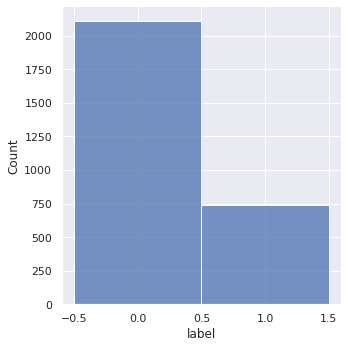

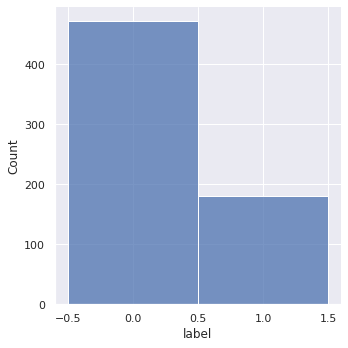

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.displot(df_train, x="label", discrete=True)
sns.displot(df_test, x="label", discrete=True).set_titles(["labels distribution train set","labels distribution test set"])

##Models

###SKLearn Models 

In [ ]:
import json

import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay ,confusion_matrix

from sklearn.model_selection import GridSearchCV
import pandas as pd
import os
import pickle
# from imblearn.pipeline import make_pipeline, Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
from collections import Counter 

!mkdir ./trained_models
!mkdir ./trained_models/ada_boost
!mkdir ./trained_models/logistic_regression
!mkdir ./trained_models/svm_linear
!mkdir ./trained_models/svm_non_linear

class SKLearnInference(object):
    def __init__(self):
        self.model_instance = None
        self.base_path = None
        self.parameters = None
        self.best_params = None

    def fit(self, x_train, y_train):
        auc_scorer = make_scorer(roc_auc_score)
        # ~~ COUDN'T USE OVER AND UNDER SAMPLING BECAUSE OF THE ASSIGNMENT GUIDLINES!
        # over and under sampling
        # over_sampler = SMOTE()
        # under_sampler = RandomUnderSampler()
        # self.parameters['o__sampling_strategy'] = [lambda y: Counter(y_train), 0.5, 1]
        # self.parameters['u__sampling_strategy'] = [lambda y: Counter(y_train), 1]
        # pipeline
        # pipeline = Pipeline(steps=[('o', over_sampler), ('u', under_sampler), ('m', self.model_instance)])
        # Run the grid search
        self.grid_obj = GridSearchCV(self.model_instance, self.parameters,
                                     scoring=auc_scorer,
                                     return_train_score=True, n_jobs=-1, verbose=4)
        self.grid_obj = self.grid_obj.fit(x_train, y_train)

        scores = pd.DataFrame(self.grid_obj.cv_results_)
        print("mean_test_score: ", max(scores['mean_test_score']))
        best_params = self.grid_obj.best_params_
        print("best_params:")
        print(best_params)

        self.model_instance = self.grid_obj.best_estimator_
        self.model_instance.fit(x_train, y_train)
        self.best_params = best_params

    def evaluate(self, x_dev, y_dev):
        predicts_dev = self.model_instance.predict(x_dev)
        auc = roc_auc_score(y_dev, predicts_dev)
        acc =  accuracy_score(y_dev, predicts_dev)
        cls_report = classification_report(y_dev, predicts_dev)
        conf_mat = confusion_matrix(y_dev, predicts_dev)
        return auc, acc, cls_report, conf_mat

    def save(self, num):
        if not os.path.isdir(self.base_path):
            os.makedirs(self.base_path)

        filename = self.base_path + "\\inference_model_{}.json".format(num)
        pickle.dump(self.model_instance, open(filename, 'wb'))

        best_params_filename = self.base_path + "\\inference_model_{}_best_params.json".format(num)
        with open(best_params_filename, 'wb') as fp:
            pickle.dump(self.grid_obj.best_params_, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print("Saved model to disk num:{}".format(num))

    def load(self, num):
        if not os.path.isdir(self.base_path):
            print("no model was saved yet")
        else:
            # load json and create model
            filename = self.base_path + "\\inference_model_{}.json".format(num)
            self.model_instance = pickle.load(open(filename, 'rb'))
            print("Loaded model from disk")

    def predict(self, x, probs=False):
        if probs:
            predicts = self.model_instance.predict_proba(x)
        else:
            predicts = self.model_instance.predict(x)
        return predicts

    def predict_prob(self, x):
        predicts_prob = self.model_instance.predict_proba(x)
        return predicts_prob

    def get_best_params(self, string=False):
        if string:
            return json.dumps(self.best_params)
        else:
            return self.best_params



In [ ]:
from numpy.random.mtrand import seed
import time

def train_sklearn_inference_model(model, inputs_train, y_train, save_index, init_seed, kernel=None):
    # Setting the random seed
    seed(init_seed)
    # ~~ initializing the model
    if kernel is None:
      sklearn_inference_model = model(init_seed)
    else:
      sklearn_inference_model = model(init_seed, kernel)
    # ~~ Train on the training set
    start = time.time()
    sklearn_inference_model.fit(inputs_train, y_train)
    end = time.time()
    print(f"training time (seconds) {end - start}")
    sklearn_inference_model.save(save_index)

    return sklearn_inference_model

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

class LogisticRegressionInference(SKLearnInference):
    def __init__(self, random_state):
        super().__init__()
        self.model_instance = LogisticRegression(random_state=random_state)
        self.base_path = "./trained_models/random_forest"
        self.parameters = {'class_weight': [None, 'balanced'], # The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data
                           'C':[0.001,.009,0.01,.09,1,5,10,25],
                           'penalty': ['l1', 'l2'],
                           'solver': ['liblinear','saga']
                           }

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


mean_test_score:  0.6648501170674495
best_params:
{'C': 25, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
training time (seconds) 267.96914768218994
Saved model to disk num:0
auc: 0.647544245715891
accuracy: 0.655436447166922
              precision    recall  f1-score   support

       False       0.82      0.67      0.74       472
        True       0.42      0.63      0.50       181

    accuracy                           0.66       653
   macro avg       0.62      0.65      0.62       653
weighted avg       0.71      0.66      0.67       653



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


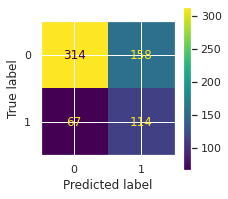

In [ ]:
random_seed = 0
save_index = 0
import matplotlib.pyplot as plt

logistic_regression_model = train_sklearn_inference_model(model=LogisticRegressionInference, inputs_train=np.vstack(df_train["embeddings_mean"]), y_train=np.asarray(df_train["label"]), save_index=save_index, init_seed=random_seed)

auc_logistic_regression, acc_logistic_regression, cls_report_logistic_regression, conf_matrix_logistic_regression = logistic_regression_model.evaluate(x_dev=np.vstack(df_test["embeddings_mean"]), y_dev=np.asarray(df_test["label"]))
print(f"auc: {auc_logistic_regression}")
print(f"accuracy: {acc_logistic_regression}")
print(cls_report_logistic_regression)
fig, ax = plt.subplots(figsize=(3,3))
ConfusionMatrixDisplay(conf_matrix_logistic_regression, display_labels=[0,1]).plot(values_format='d', ax=ax)

In [ ]:
# train_data = np.array([np.array(token_embeddings) for token_embeddings in df_train_splitted.tokens_embeddings])
# train_data = train_data.reshape(train_data.shape[0], train_data.shape[1]*train_data.shape[2])
# test_data = np.array([np.array(token_embeddings) for token_embeddings in df_test_splitted.tokens_embeddings])
# test_data = test_data.reshape(test_data.shape[0], test_data.shape[1]*test_data.shape[2])


In [ ]:
# logistic_regression_model_seq = train_sklearn_inference_model(model=LogisticRegressionInference, inputs_train=train_data, y_train=np.asarray(df_train_splitted["label"]), save_index=save_index, init_seed=random_seed)

# auc_logistic_regression_seq, acc_logistic_regression_seq, cls_report_logistic_regression_seq, conf_matrix_logistic_regression_seq = logistic_regression_model_seq.evaluate(x_dev=test_data, y_dev=np.asarray(df_test_splitted["label"]))
# print(f"auc: {auc_logistic_regression_seq}")
# print(f"accuracy: {acc_logistic_regression_seq}")
# print(cls_report_logistic_regression_seq)
# ConfusionMatrixDisplay(conf_matrix_logistic_regression_seq, display_labels=[0,1]).plot(values_format='d')

### SVM Linear Kernel

In [ ]:
from sklearn.svm import SVC
class SVCInference(SKLearnInference):
    def __init__(self, random_state, kernel):
        super().__init__()
        self.model_instance = SVC(random_state=random_state, kernel=kernel)
        self.base_path = "./trained_models/SVC/"+kernel
        self.parameters = {'class_weight': [None, 'balanced'], # The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data
                           'C':[0.001,.009,0.01,.09,1,5,10,25],
                           'decision_function_shape': ['ovo', 'ovr'],
                           'gamma': ['scale', 'auto']
                           }

Fitting 5 folds for each of 64 candidates, totalling 320 fits
mean_test_score:  0.6650234962692647
best_params:
{'C': 5, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': 'scale'}
training time (seconds) 359.37102794647217
Saved model to disk num:0
auc: 0.6660092237100853
accuracy: 0.6722817764165391
              precision    recall  f1-score   support

       False       0.84      0.68      0.75       472
        True       0.44      0.65      0.52       181

    accuracy                           0.67       653
   macro avg       0.64      0.67      0.64       653
weighted avg       0.73      0.67      0.69       653



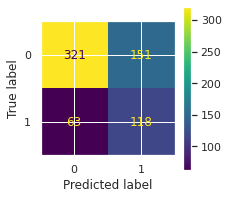

In [ ]:
linear_svc_model = train_sklearn_inference_model(model=SVCInference, inputs_train=np.vstack(df_train["embeddings_mean"]), y_train=np.asarray(df_train["label"]), save_index=save_index, init_seed=random_seed, kernel='linear')

auc_linear_svc, acc_linear_svc, cls_report_linear_svc, conf_matrix_linear_svc = linear_svc_model.evaluate(x_dev=np.vstack(df_test["embeddings_mean"]), y_dev=np.asarray(df_test["label"]))
print(f"auc: {auc_linear_svc}")
print(f"accuracy: {acc_linear_svc}")
print(cls_report_linear_svc)
fig, ax = plt.subplots(figsize=(3,3))
ConfusionMatrixDisplay(conf_matrix_linear_svc, display_labels=[0,1]).plot(values_format='d', ax=ax)

In [ ]:
pickle.dump(linear_svc_model.model_instance, open("linear_svc_best_model.sav", 'wb'))

### SVM Non-Linear Kernel

Fitting 5 folds for each of 64 candidates, totalling 320 fits
mean_test_score:  0.681263217468363
best_params:
{'C': 10, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': 'scale'}
training time (seconds) 529.45862865448
Saved model to disk num:0
auc: 0.6606306770296845
accuracy: 0.6891271056661562
              precision    recall  f1-score   support

       False       0.82      0.72      0.77       472
        True       0.45      0.60      0.52       181

    accuracy                           0.69       653
   macro avg       0.64      0.66      0.64       653
weighted avg       0.72      0.69      0.70       653



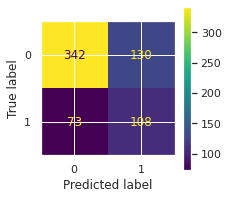

In [ ]:
rbf_svc_model = train_sklearn_inference_model(model=SVCInference, inputs_train=np.vstack(df_train["embeddings_mean"]), y_train=np.asarray(df_train["label"]), save_index=save_index, init_seed=random_seed, kernel='rbf')

auc_rbf_svc, acc_rbf_svc, cls_report_rbf_svc, conf_matrix_rbf_svc = rbf_svc_model.evaluate(x_dev=np.vstack(df_test["embeddings_mean"]), y_dev=np.asarray(df_test["label"]))
print(f"auc: {auc_rbf_svc}")
print(f"accuracy: {acc_rbf_svc}")
print(cls_report_rbf_svc)
fig, ax = plt.subplots(figsize=(3,3))
ConfusionMatrixDisplay(conf_matrix_rbf_svc, display_labels=[0,1]).plot(values_format='d', ax=ax)

### Ada-Boost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


class AdaBoostInference(SKLearnInference):
    def __init__(self, random_state):
        super().__init__()
        self.model_instance = AdaBoostClassifier(random_state=random_state)
        self.base_path = "./trained_models/ada_boost"
        base_estimators = []
        for max_features in ['log2', 'sqrt']:
            for criterion in ['entropy', 'gini']:
                for max_depth in [5, 10]:
                    for min_samples_split in [2, 3, 5]:
                        for min_samples_leaf in [1, 5, 8]:
                            base_estimators.append(DecisionTreeClassifier(
                                max_features=max_features, criterion=criterion, max_depth=max_depth,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf))
        self.parameters = {'n_estimators': [100, 150, 300],
                           'base_estimator': base_estimators
                           }

    def get_best_params(self, string=False):
        if string:
            self.best_params['base_estimator'] = str(self.best_params['base_estimator'])
            return super().get_best_params(string=string)
        else:
            return super().get_best_params(string=string)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
mean_test_score:  0.5918770133902158
best_params:
{'base_estimator': DecisionTreeClassifier(max_depth=5, max_features='log2', min_samples_leaf=5), 'n_estimators': 300}
training time (seconds) 5346.4332394599915
Saved model to disk num:0
auc: 0.5664212473078003
accuracy: 0.7228177641653905
              precision    recall  f1-score   support

       False       0.75      0.92      0.83       472
        True       0.50      0.22      0.30       181

    accuracy                           0.72       653
   macro avg       0.63      0.57      0.56       653
weighted avg       0.68      0.72      0.68       653



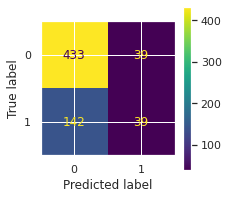

In [ ]:
ada_boost_model = train_sklearn_inference_model(model=AdaBoostInference, inputs_train=np.vstack(df_train["embeddings_mean"]), y_train=np.asarray(df_train["label"]), save_index=save_index, init_seed=random_seed)

auc_ada_boost, acc_ada_boost, cls_report_ada_boost, conf_matrix_ada_boost = ada_boost_model.evaluate(x_dev=np.vstack(df_test["embeddings_mean"]), y_dev=np.asarray(df_test["label"]))
print(f"auc: {auc_ada_boost}")
print(f"accuracy: {acc_ada_boost}")
print(cls_report_ada_boost)
fig, ax = plt.subplots(figsize=(3,3))
ConfusionMatrixDisplay(conf_matrix_ada_boost, display_labels=[0,1]).plot(values_format='d',ax=ax)

##PyTorch Models

###Neural Network Classifier

In [ ]:
!pip install torch

In [ ]:
from torch import nn
import torch.nn.functional as F
from torch.utils import data
from torch import tensor
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

class NNModel(nn.Module):
    def __init__(self, layers_sizes): #vocab_size,
        super(NNModel, self).__init__()
        # self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(layers_sizes[0], layers_sizes[1]),
            nn.ReLU(),
            nn.Linear(layers_sizes[1], layers_sizes[2]),
            nn.ReLU(),
            nn.Linear(layers_sizes[2], layers_sizes[3]),
            nn.ReLU(),
            nn.Linear(layers_sizes[3], layers_sizes[4])
        )

    def forward(self, x):
        logits = torch.sigmoid(self.linear_relu_stack(x))
        return logits


In [ ]:
import time 
def train_epoch(model, opt, crit, dataloader):
    model.train(mode=True) #setting the model to training mode

    for idx, (x,y) in enumerate(dataloader):
        predicted_label = model(x)
        # print(predicted_label)
        loss = crit(predicted_label, y)
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        # nn.utils.clip_grad_norm_(model.parameters(), 0.1)

def evaluate_nn(model, x_dev, y_dev):
    model.eval()
    with torch.no_grad():
      predicts_dev = model(x_dev).round()
      # print(predicts_dev)
      auc = roc_auc_score(y_dev, predicts_dev)
      acc =  accuracy_score(y_dev, predicts_dev)
      cls_report = classification_report(y_dev, predicts_dev)
      conf_mat = confusion_matrix(y_dev, predicts_dev)
      return auc, acc, cls_report, conf_mat

def evaluate_nn_auc(model, x_dev, y_dev):
    model.eval()
    with torch.no_grad():
      predicts_dev = model(x_dev).round()
      # print(predicts_dev)
      auc = roc_auc_score(y_dev, predicts_dev)
    return auc


def evaluate(model, crit, dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (x,y) in enumerate(dataloader):
            predicted_label = model(x)
            # print(predicted_label)
            # print(predicted_label.argmax(1))
            # print(predicted_label.round())
            # loss = crit(predicted_label, y)
            total_acc += (predicted_label.round() == y).sum().item()
            total_count += y.size(0)
    return total_acc/total_count

def train(model, opt, crit, scheduler, train_dataloader, test_dataloader, test_data_tensor, test_labels_tensor, epochs):
  total_accuracy = None

  for epoch in range(1, epochs + 1):
      epoch_start_time = time.time()
      train_epoch(model=model, opt=opt, crit=crit, dataloader=train_dataloader)
      accuracy_val = evaluate(model=model, crit=crit, dataloader=test_dataloader)
      scheduler.step()
      # auc_val = evaluate_nn_auc(model, x_dev=test_data_tensor, y_dev=np.asarray(df_test["label"]))
      auc_val = evaluate_nn_auc(model, x_dev=test_data_tensor, y_dev=test_labels_tensor)
      print('-' * 59)
      print('| end of epoch {:3d} | time: {:5.2f}s | '
            'valid accuracy {:8.3f} '.format(epoch,
                                            time.time() - epoch_start_time,
                                            accuracy_val))
      print(f"auc_val: {auc_val}, last_lr: {str(scheduler.get_last_lr())}")

# from torch.utils.data.dataset import random_split
# from torchtext.data.functional import to_map_style_dataset
# # Hyperparameters
# EPOCHS = 10 # epoch
# LR = 5  # learning rate
# BATCH_SIZE = 64 # batch size for training

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
# total_accu = None
# train_iter, test_iter = AG_NEWS()
# train_dataset = to_map_style_dataset(train_iter)
# test_dataset = to_map_style_dataset(test_iter)

#~~Validation set
# num_train = int(len(train_dataset) * 0.95)
# split_train_, split_valid_ = \
#     random_split(train_dataset, [num_train, len(train_dataset) - num_train])

# train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
#                               shuffle=True, collate_fn=collate_batch)
# valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
#                               shuffle=True, collate_fn=collate_batch)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
#                              shuffle=True, collate_fn=collate_batch)



In [ ]:
batch_size = 16 # batch size for training

# Data preperation
def arrange_data_for_nn(train_data, test_data, train_labels, test_labels):
  train_data_tensor = tensor(train_data)
  test_data_tensor = tensor(test_data)

  train_labels_tensor = tensor(train_labels)
  test_labels_tensor = tensor(test_labels)
  # labels_tr = np.asarray(train_df["label"]).astype(int)
  # labels_te = np.asarray(test_df["label"]).astype(int)

  # train_label = tensor(np.eye(np.max(labels_tr) + 1)[labels_tr].astype(np.float32))
  # test_label = tensor(np.eye(np.max(labels_te) + 1)[labels_te].astype(np.float32))

  train_tensor = data.TensorDataset(train_data_tensor, train_labels_tensor) 
  test_tensor = data.TensorDataset(test_data_tensor, test_labels_tensor) 

  trainloader = data.DataLoader(train_tensor, batch_size=batch_size,
                                            shuffle=True)
  testloader = data.DataLoader(test_tensor, batch_size=batch_size,
                                          shuffle=False)
  return trainloader, testloader, test_data_tensor, test_labels_tensor

trainloader, testloader, test_data_tensor, test_labels_tensor = arrange_data_for_nn(train_data=np.vstack(df_train["embeddings_mean"]), test_data=np.vstack(df_test["embeddings_mean"]),train_labels=np.vstack(df_train["label"]).astype(np.float32), test_labels=np.vstack(df_test["label"]).astype(np.float32))

In [ ]:
# Hyperparameters
input_size = np.vstack(df_train["embeddings_mean"]).shape[1]
output_size = 1
layers_sizes=[input_size, int(input_size/2), int(input_size/4), int(input_size/8), output_size]


epochs = 300 # epoch
learning_rate = 0.1  # learning rate
batch_size = 16 # batch size for training

# Model initialization
nn_model = NNModel(layers_sizes=layers_sizes)
print(nn_model)

criterion = nn.BCELoss()
optimizer = optim.SGD(nn_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10.0, gamma=0.8)

NNModel(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=300, out_features=150, bias=True)
    (1): ReLU()
    (2): Linear(in_features=150, out_features=75, bias=True)
    (3): ReLU()
    (4): Linear(in_features=75, out_features=37, bias=True)
    (5): ReLU()
    (6): Linear(in_features=37, out_features=1, bias=True)
  )
)


In [ ]:
train(model=nn_model, opt=optimizer, crit=criterion, scheduler=scheduler, train_dataloader=trainloader, test_dataloader=testloader, test_data_tensor=test_data_tensor, test_labels_tensor=test_labels_tensor, epochs=epochs)

-----------------------------------------------------------
| end of epoch   1 | time:  0.67s | valid accuracy    0.723 
auc_val: 0.5, last_lr: [0.1]
-----------------------------------------------------------
| end of epoch   2 | time:  0.22s | valid accuracy    0.723 
auc_val: 0.5, last_lr: [0.1]
-----------------------------------------------------------
| end of epoch   3 | time:  0.34s | valid accuracy    0.723 
auc_val: 0.5, last_lr: [0.1]
-----------------------------------------------------------
| end of epoch   4 | time:  0.23s | valid accuracy    0.723 
auc_val: 0.5, last_lr: [0.1]
-----------------------------------------------------------
| end of epoch   5 | time:  0.21s | valid accuracy    0.723 
auc_val: 0.5, last_lr: [0.1]
-----------------------------------------------------------
| end of epoch   6 | time:  0.23s | valid accuracy    0.723 
auc_val: 0.5, last_lr: [0.1]
-----------------------------------------------------------
| end of epoch   7 | time:  0.23s | vali

In [ ]:
evaluate(model=nn_model, crit=criterion, dataloader=testloader)

0.7197549770290965

auc: 0.6273176327371477
accuracy: 0.7197549770290965
              precision    recall  f1-score   support

         0.0       0.79      0.83      0.81       472
         1.0       0.49      0.42      0.45       181

    accuracy                           0.72       653
   macro avg       0.64      0.63      0.63       653
weighted avg       0.71      0.72      0.71       653



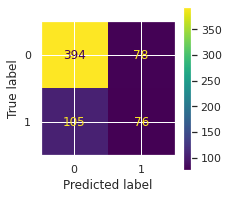

In [ ]:
auc_nn, acc_nn, cls_report_nn, conf_matrix_nn = evaluate_nn(nn_model, x_dev=test_data_tensor, y_dev=test_labels_tensor)
print(f"auc: {auc_nn}")
print(f"accuracy: {acc_nn}")
print(cls_report_nn)
fig, ax = plt.subplots(figsize=(3,3))
ConfusionMatrixDisplay(conf_matrix_nn, display_labels=[0,1]).plot(values_format='d',ax=ax)

In [ ]:
train_data = np.array([np.array(token_embeddings) for token_embeddings in df_train_splitted.tokens_embeddings])
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1]*train_data.shape[2])
test_data = np.array([np.array(token_embeddings) for token_embeddings in df_test_splitted.tokens_embeddings])
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1]*test_data.shape[2])

In [ ]:
test_data.shape

(1017, 3000)

In [ ]:
np.vstack(df_test_splitted["label"]).astype(np.float32).shape

(1017, 1)

In [ ]:
# Hyperparameters
input_size = 3000
output_size = 1
layers_sizes=[input_size, int(input_size/2), int(input_size/4), int(input_size/8), output_size]


epochs = 300 # epoch
learning_rate = 0.05  # learning rate
batch_size = 16 # batch size for training

# Model initialization
nn_model_seq = NNModel(layers_sizes=layers_sizes)
print(nn_model_seq)

criterion = nn.BCELoss()
optimizer = optim.SGD(nn_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10.0, gamma=0.8)


trainloader, testloader, test_data_tensor, test_labels_tensor = arrange_data_for_nn(train_data=train_data, test_data=test_data,train_labels=np.vstack(df_train_splitted["label"]).astype(np.float32), test_labels=np.vstack(df_test_splitted["label"]).astype(np.float32))

train(model=nn_model_seq, opt=optimizer, crit=criterion, scheduler=scheduler, train_dataloader=trainloader, test_dataloader=testloader, test_data_tensor=test_data_tensor, test_labels_tensor=test_labels_tensor, epochs=epochs)


NNModel(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3000, out_features=1500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1500, out_features=750, bias=True)
    (3): ReLU()
    (4): Linear(in_features=750, out_features=375, bias=True)
    (5): ReLU()
    (6): Linear(in_features=375, out_features=1, bias=True)
  )
)
-----------------------------------------------------------
| end of epoch   1 | time:  5.88s | valid accuracy    0.767 
auc_val: 0.5, last_lr: [0.05]
-----------------------------------------------------------
| end of epoch   2 | time:  5.73s | valid accuracy    0.767 
auc_val: 0.5, last_lr: [0.05]
-----------------------------------------------------------
| end of epoch   3 | time:  5.72s | valid accuracy    0.767 
auc_val: 0.5, last_lr: [0.05]
-----------------------------------------------------------
| end of epoch   4 | time:  5.71s | valid accuracy    0.767 
auc_val: 0.5, last_lr: [0.05]
-------------------------------------------------

auc: 0.5
accuracy: 0.7669616519174042
              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87       780
         1.0       0.00      0.00      0.00       237

    accuracy                           0.77      1017
   macro avg       0.38      0.50      0.43      1017
weighted avg       0.59      0.77      0.67      1017



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


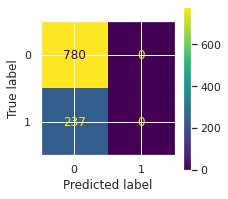

In [ ]:
auc_nn_seq, acc_nn_seq, cls_report_nn_seq, conf_matrix_nn_seq = evaluate_nn(nn_model_seq, x_dev=test_data_tensor, y_dev=test_labels_tensor)
print(f"auc: {auc_nn_seq}")
print(f"accuracy: {acc_nn_seq}")
print(cls_report_nn_seq)
fig, ax = plt.subplots(figsize=(3,3))
ConfusionMatrixDisplay(conf_matrix_nn_seq, display_labels=[0,1]).plot(values_format='d', ax=ax)

###Recurent Neural Network

In [ ]:
from torch import nn
import torch.nn.functional as F
from torch.utils import data
from torch import tensor
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

class LSTMRNNModel(nn.Module):
    def __init__(self, layers_sizes, input_size, hidden_dim, num_layers):#embedding_dim=300, hidden_dim=200
        super(LSTMRNNModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.num_layers = num_layers
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_size, 
                            hidden_dim, 
                            bidirectional=False,
                            batch_first=True, 
                            num_layers=2)
        # x needs to be: (batch_size, seq, input_size)

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(layers_sizes[0], layers_sizes[1]),
            nn.ReLU(),
            nn.Linear(layers_sizes[1], layers_sizes[2])
        )


    def forward(self, x):
        batch_len = x.size(0)
        h0 = torch.randn(self.num_layers, batch_len, self.hidden_dim)
        c0 = torch.randn(self.num_layers, batch_len, self.hidden_dim) 

        lstm_out, _ = self.lstm(x, (h0,c0))
        # lstm_out: tensor of shape (batch_size, seq_length, hidden_size)
        # lstm_out: (batch_size, 10, 200)

        #we only want the output of the last time step - > (batch_size, hidden_size)
        lstm_out = lstm_out[:, -1, :]

        out = torch.sigmoid(self.linear_relu_stack(lstm_out))
        return out

In [ ]:
train_data = np.array([np.array(token_embeddings) for token_embeddings in df_train_splitted.tokens_embeddings])
test_data = np.array([np.array(token_embeddings) for token_embeddings in df_test_splitted.tokens_embeddings])


trainloader, testloader, test_data_tensor, test_labels_tensor = arrange_data_for_nn(train_data=train_data, test_data=test_data,train_labels=np.vstack(df_train_splitted["label"]).astype(np.float32), test_labels=np.vstack(df_test_splitted["label"]).astype(np.float32))



In [ ]:
# Hyperparameters
input_size = 300
output_size=1
hidden_dim = 128
sequence_length = 10
num_layers = 2
layers_sizes=[hidden_dim, int(hidden_dim/4), output_size] #hidden_dim*2 for bidirectional lstm

epochs = 300 # epoch
learning_rate = 0.1  # learning rate
batch_size = 16 # batch size for training

# Model initialization
lstm_model = LSTMRNNModel(layers_sizes=layers_sizes, input_size=input_size, hidden_dim=hidden_dim, num_layers=num_layers)
print(lstm_model)

criterion = nn.BCELoss()
optimizer = optim.SGD(lstm_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10.0, gamma=0.8)



LSTMRNNModel(
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
!pip install torchviz


  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=ef7a0b0b28e49409cc14a7f171303420e7d88ced1d0f0873f78622c74c0c46bc
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
from torchviz import make_dot
batch = next(iter(trainloader))

make_dot(lstm_model(batch[0]), params=dict(list(lstm_model.named_parameters()))).render("rnn_torchviz", format="jpeg")

'rnn_torchviz.jpeg'

In [ ]:
train(model=lstm_model, opt=optimizer, crit=criterion, scheduler=scheduler, train_dataloader=trainloader, test_dataloader=testloader, test_data_tensor=test_data_tensor, test_labels_tensor=test_labels_tensor, epochs=epochs)

-----------------------------------------------------------
| end of epoch   1 | time:  4.63s | valid accuracy    0.767 
auc_val: 0.5, last_lr: [0.1]
-----------------------------------------------------------
| end of epoch   2 | time:  8.91s | valid accuracy    0.767 
auc_val: 0.5, last_lr: [0.1]
-----------------------------------------------------------
| end of epoch   3 | time: 10.28s | valid accuracy    0.767 
auc_val: 0.5, last_lr: [0.1]
-----------------------------------------------------------
| end of epoch   4 | time:  8.27s | valid accuracy    0.767 
auc_val: 0.5, last_lr: [0.1]
-----------------------------------------------------------
| end of epoch   5 | time:  8.50s | valid accuracy    0.767 
auc_val: 0.5, last_lr: [0.1]
-----------------------------------------------------------
| end of epoch   6 | time:  5.56s | valid accuracy    0.767 
auc_val: 0.5, last_lr: [0.1]
-----------------------------------------------------------
| end of epoch   7 | time:  3.96s | vali

In [ ]:
evaluate(model=lstm_model, crit=criterion, dataloader=testloader)

0.7354965585054081

auc: 0.5777831872768582
accuracy: 0.744346116027532
              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84       780
         1.0       0.42      0.27      0.33       237

    accuracy                           0.74      1017
   macro avg       0.61      0.58      0.58      1017
weighted avg       0.71      0.74      0.72      1017



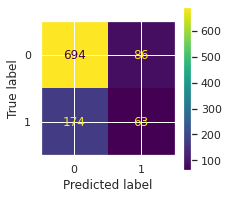

In [ ]:
auc_lstm, acc_lstm, cls_report_lstm, conf_matrix_lstm = evaluate_nn(lstm_model, x_dev=test_data_tensor, y_dev=test_labels_tensor)
print(f"auc: {auc_lstm}")
print(f"accuracy: {acc_lstm}")
print(cls_report_lstm)
fig, ax = plt.subplots(figsize=(3,3))
ConfusionMatrixDisplay(conf_matrix_lstm, display_labels=[0,1]).plot(values_format='d',ax=ax)

In [ ]:
np.array([np.array(token_embeddings) for token_embeddings in df_train_splitted.tokens_embeddings]).shape

(4056, 10, 300)